In [24]:
from tic_env import TictactoeEnv, OptimalPlayer
from performance_measures import M_opt, M_rand
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from tqdm.notebook import tqdm

## Q-Learning combined with epsilon-greedy policy. 

At each time $t$, state $s_t$ is the board position, action $a_t$ is one of the available positions on the board and reward $r_t$. <br>
The reward only non-zero when the game ends where you get $r_t = 1$ if you win the game, $r_t = 1$ if you lose, and $r_t=0$ if it is a draw.

Q-Learning has 3 hyper-parameters: 
- learning rate $\alpha$
- discount factor $\gamma$
- and exploration level $\epsilon$ 

For convenience, we fix the learning rate at alpha = 0.05 and the discount factor at $\gamma$ = 0.99. <br>
We initialize all the Q-values at 0. <br>
If you are curious, you can explore the effect of $\alpha$, $\gamma$ and initial Q-values for yourself. <br>

In [2]:
alpha = 0.05 # learning rate 
gamma = 0.99 # discount factor
epsilon = 0.1 # exploration rate

Data structure to save our Q values

In [64]:
# stores only one value that it returns on any key
class FinalState():
    def __init__(self):
        self.value = 0
    def __getitem__(self, key):
        return self.value
    def __setitem__(self, key, value):
        self.value = value
    def values(self):
        return [self.value]
    def __repr__(self):
        return "{any: " + str(self.value) + "}"

# Q_table[state][move]
class QTable(dict):
    def __getitem__(self, key):
        self.__check_key(key)
        return super().__getitem__(self.__to_tuple(key))
    def __setitem__(self, key, value):
        self.__check_key(key)
        super().__setitem__(self.__to_tuple(key), value)
    def __missing__(self, key):
        arr = self.__to_array(key)
        non_zero_locations = list(zip(*np.nonzero(arr == 0)))
        if len(non_zero_locations) == 0:
            ret = self[arr] = FinalState()
            return ret
        ret = self[arr] = {k: 0 for k in non_zero_locations}
        return ret
    def __check_key(self, key):
        if not isinstance(key, np.ndarray):
            raise(TypeError("QTable only accepts np.ndarray of as keys"))
        if key.shape != (3, 3):
            raise(ValueError("QTable only accepts np.ndarray of shape (3, 3)"))
    def __to_array(self, key):
        if isinstance(key, tuple):
            key = np.array(key).reshape(3, 3)
        return key
    def __to_tuple(self, key):
        if isinstance(key, np.ndarray):
            key = tuple(key.reshape(-1))
        return key

In [65]:
Q = QTable()
Q

{}

In [67]:
Q[np.ones((3, 3))]

{any: 0}

In [68]:
Q[np.ones((3, 3))]["any action"] = 2
Q[np.ones((3, 3))]

{any: 2}

### 2.1 Learning from experts

In this section, you will study whether Q-learning can learn to play Tic Tac Toe by playing against `Opt(`$\epsilon_{opt}$`)` for some $\epsilon_{opt} \in [0; 1]$. <br> 
To do so, implement the Q-learning algorithm. To check the algorithm, run a Q-learning agent, with a fixed and arbitrary $\epsilon_{opt} \in [0; 1)$ against `Opt(0.5)` for 20'000 games. <br> 
Switch the 1st player after every game.

In [15]:
env = TictactoeEnv()
Q_table = QTable()
rewards = []
num_trained_episodes = 0

def epslion_greedy(state):
    Q_actions = Q_table[state]
    if np.random.random() < epsilon:
        actions = list(Q_actions.keys())
        if len(actions) == 1:
            return actions[0]
        return actions[np.random.randint(0, len(actions)-1)]
    else:
        return max(Q_actions, key=Q_actions.get)

In [69]:
num_episodes = 100000
opt_player = OptimalPlayer(0.5, player='O')
learning_player = 'X'

for itr in tqdm(range(num_episodes), desc="Q-learning training"):
    env.reset()
    state, end, _ = env.observe()

    # opt_player.player, learning_player = learning_player, opt_player.player

    if opt_player.player == 'X':
        move = opt_player.act(state)
        state, end, _ = env.step(move)

    while not end:
        move = epslion_greedy(state)
        state, end, _ = env.step(move)

        if env.current_player == opt_player.player and not end:
            state, end, _ = env.observe()
            move = opt_player.act(state)
            next_state, end, _ = env.step(move)
            reward = env.reward(player=learning_player)
            
            if end:
                Q[state][move] = reward

            Q_table[state][move] = Q_table[state][move] + alpha * (reward + gamma * max(Q_table[next_state].values()) - Q_table[state][move])

        state = next_state

        # env.render()
        # time.sleep(1)
        # clear_output(wait=True)
    num_trained_episodes += 1
    rewards.append(reward)    
    env.reset()

Q-learning training:   0%|          | 0/100000 [00:00<?, ?it/s]

In [70]:
M_opt(epslion_greedy), M_rand(epslion_greedy)

(-0.986, 0.228)

In [39]:
p = OptimalPlayer(1)
M_opt(p.act), M_rand(p.act)

(-0.94, -0.002)

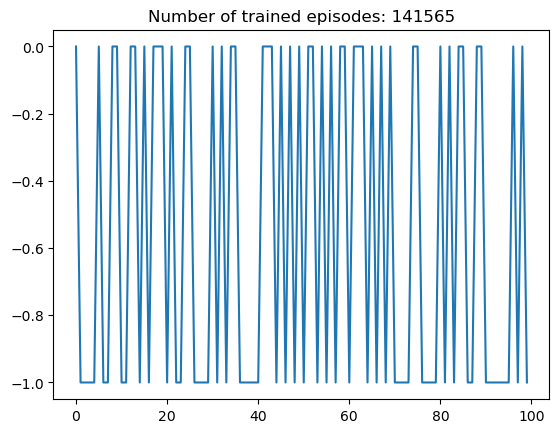

In [40]:
plt.plot(rewards[-100:])
plt.title(f"Number of trained episodes: {num_trained_episodes}")
plt.show()

In [43]:
repr(Q_table)

'{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): {(0, 0): 0, (0, 1): 0, (0, 2): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0}, (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): {(0, 1): 0.0, (0, 2): 0.0, (1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0}, (1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): {(0, 1): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0}, (1.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): {(1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0}, (1.0, 1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0): {(1, 1): 0, (1, 2): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0}, (1.0, 1.0, -1.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0): {(1, 2): 0.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0}, (1.0, 1.0, -1.0, -1.0, 1.0, 0.0, -1.0, 0.0, 0.0): {(1, 2): 0, (2, 1): 0, (2, 2): 0}, (1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 0.0, 0.0): {(2, 1): 0.0, (2, 2): 0.0}, (1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 0.0): {(2, 2): 0}, (0.0, 